## Train a GAN on the Fashion MNIST dataset
### Imports

In [2]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

### Load Data

In [3]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

### Summarize loaded dataset and plot first images

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


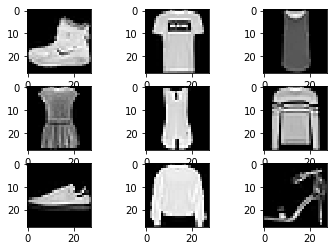

In [5]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

### Define for model

In [6]:
img_rows = 28
img_cols = 28
channels = 1
latent_dim = 100

img_shape = (img_rows, img_cols, channels)
optimizer = Adam(0.0002, 0.5)

Instructions for updating:
Colocations handled automatically by placer.


### Build the Discriminator

In [7]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [8]:
discriminator = build_discriminator(img_shape,)
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


### Build the Generator

In [9]:
def build_generator(img_shape, latent_dim):

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(2048))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [10]:
generator = build_generator(img_shape, latent_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
__________

#### The Generator takes noise as input

In [11]:
z = Input(shape=(latent_dim,))
img = generator(z)

#### For the combined model we will only train the generator

In [12]:
discriminator.trainable = False

#### The discriminator takes generated images as input and determines validity

In [13]:
validity = discriminator(img)

#### The combined model  (stacked generator and discriminator)
Trains the generator to fool the discriminator

In [14]:
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

## Train Model

In [15]:
epochs = 3000
batch_size = 32
sample_interval = 200 

Rescale -1 to 1

In [16]:
X_train = trainX / 127.5 - 1.

In [17]:
X_train = np.expand_dims(X_train, axis=3)

Adversarial ground truths

In [18]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

sample plot

In [19]:
def sample_images(epoch, latent_dim, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

0 [D loss: 0.535209, acc.: 59.38%] [G loss: 0.584135]


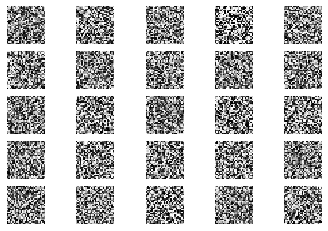

1 [D loss: 0.458512, acc.: 67.19%] [G loss: 0.674157]
2 [D loss: 0.353472, acc.: 79.69%] [G loss: 0.882352]
3 [D loss: 0.315385, acc.: 85.94%] [G loss: 0.995825]
4 [D loss: 0.285401, acc.: 87.50%] [G loss: 1.204257]
5 [D loss: 0.249427, acc.: 95.31%] [G loss: 1.317652]
6 [D loss: 0.199075, acc.: 98.44%] [G loss: 1.342953]
7 [D loss: 0.167752, acc.: 100.00%] [G loss: 1.513393]
8 [D loss: 0.158141, acc.: 100.00%] [G loss: 1.664521]
9 [D loss: 0.129032, acc.: 100.00%] [G loss: 1.739111]
10 [D loss: 0.129924, acc.: 100.00%] [G loss: 1.792197]
11 [D loss: 0.101483, acc.: 100.00%] [G loss: 1.937663]
12 [D loss: 0.112642, acc.: 100.00%] [G loss: 1.973825]
13 [D loss: 0.100774, acc.: 100.00%] [G loss: 1.988532]
14 [D loss: 0.100189, acc.: 100.00%] [G loss: 2.153240]
15 [D loss: 0.089533, acc.: 100.00%] [G loss: 2.143714]
16 [D loss: 0.067889, acc.: 100.00%] [G loss: 2.306063]
17 [D loss: 0.078579, acc.: 100.00%] [G loss: 2.371517]
18 [D loss: 0.080137, acc.: 100.00%] [G loss: 2.401424]
19 [D l

152 [D loss: 0.059986, acc.: 98.44%] [G loss: 3.683562]
153 [D loss: 0.097817, acc.: 98.44%] [G loss: 3.141622]
154 [D loss: 0.233267, acc.: 93.75%] [G loss: 3.378716]
155 [D loss: 0.152203, acc.: 95.31%] [G loss: 4.156430]
156 [D loss: 0.203255, acc.: 89.06%] [G loss: 3.915477]
157 [D loss: 0.155886, acc.: 93.75%] [G loss: 3.694638]
158 [D loss: 0.158581, acc.: 92.19%] [G loss: 3.639253]
159 [D loss: 0.225849, acc.: 90.62%] [G loss: 3.722861]
160 [D loss: 0.155313, acc.: 93.75%] [G loss: 4.058936]
161 [D loss: 0.102802, acc.: 98.44%] [G loss: 3.336324]
162 [D loss: 0.217436, acc.: 89.06%] [G loss: 3.498399]
163 [D loss: 0.267725, acc.: 89.06%] [G loss: 3.873245]
164 [D loss: 0.741976, acc.: 60.94%] [G loss: 2.335429]
165 [D loss: 0.245161, acc.: 89.06%] [G loss: 3.727830]
166 [D loss: 0.464801, acc.: 84.38%] [G loss: 2.668697]
167 [D loss: 0.181641, acc.: 90.62%] [G loss: 3.308669]
168 [D loss: 0.195217, acc.: 95.31%] [G loss: 2.860352]
169 [D loss: 0.217192, acc.: 90.62%] [G loss: 3.

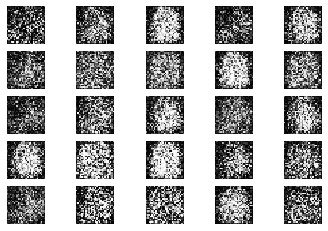

201 [D loss: 0.212939, acc.: 90.62%] [G loss: 2.932452]
202 [D loss: 0.316613, acc.: 82.81%] [G loss: 3.656704]
203 [D loss: 0.279255, acc.: 93.75%] [G loss: 2.865423]
204 [D loss: 0.363199, acc.: 85.94%] [G loss: 2.759221]
205 [D loss: 0.396392, acc.: 79.69%] [G loss: 2.547541]
206 [D loss: 0.327678, acc.: 84.38%] [G loss: 2.768875]
207 [D loss: 0.467218, acc.: 78.12%] [G loss: 3.074249]
208 [D loss: 0.554829, acc.: 70.31%] [G loss: 2.686170]
209 [D loss: 0.292762, acc.: 95.31%] [G loss: 3.802789]
210 [D loss: 0.966136, acc.: 53.12%] [G loss: 1.660666]
211 [D loss: 0.348506, acc.: 85.94%] [G loss: 3.374874]
212 [D loss: 0.383249, acc.: 82.81%] [G loss: 2.930736]
213 [D loss: 0.322867, acc.: 90.62%] [G loss: 2.450522]
214 [D loss: 0.367939, acc.: 84.38%] [G loss: 3.184339]
215 [D loss: 0.820876, acc.: 56.25%] [G loss: 2.254941]
216 [D loss: 0.359890, acc.: 82.81%] [G loss: 2.757606]
217 [D loss: 0.486554, acc.: 70.31%] [G loss: 2.838532]
218 [D loss: 0.579422, acc.: 75.00%] [G loss: 2.

352 [D loss: 0.699568, acc.: 57.81%] [G loss: 0.976580]
353 [D loss: 0.642418, acc.: 62.50%] [G loss: 0.987850]
354 [D loss: 0.697828, acc.: 56.25%] [G loss: 0.944091]
355 [D loss: 0.736435, acc.: 50.00%] [G loss: 0.932769]
356 [D loss: 0.670783, acc.: 60.94%] [G loss: 0.906810]
357 [D loss: 0.684607, acc.: 67.19%] [G loss: 0.971700]
358 [D loss: 0.789445, acc.: 62.50%] [G loss: 0.962242]
359 [D loss: 0.651379, acc.: 71.88%] [G loss: 0.999346]
360 [D loss: 0.664193, acc.: 59.38%] [G loss: 0.965748]
361 [D loss: 0.701387, acc.: 59.38%] [G loss: 0.980118]
362 [D loss: 0.696412, acc.: 56.25%] [G loss: 0.911877]
363 [D loss: 0.678009, acc.: 70.31%] [G loss: 0.897606]
364 [D loss: 0.632526, acc.: 64.06%] [G loss: 0.833571]
365 [D loss: 0.658066, acc.: 65.62%] [G loss: 0.892811]
366 [D loss: 0.576707, acc.: 70.31%] [G loss: 0.983528]
367 [D loss: 0.708631, acc.: 56.25%] [G loss: 0.931644]
368 [D loss: 0.579756, acc.: 65.62%] [G loss: 0.963043]
369 [D loss: 0.662668, acc.: 59.38%] [G loss: 0.

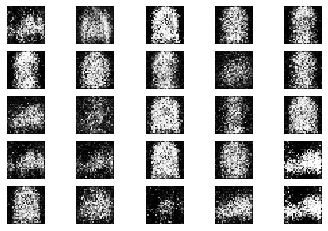

401 [D loss: 0.671102, acc.: 51.56%] [G loss: 0.886281]
402 [D loss: 0.699184, acc.: 51.56%] [G loss: 0.898369]
403 [D loss: 0.649566, acc.: 54.69%] [G loss: 0.914704]
404 [D loss: 0.626266, acc.: 68.75%] [G loss: 0.920469]
405 [D loss: 0.630325, acc.: 67.19%] [G loss: 0.852067]
406 [D loss: 0.694730, acc.: 57.81%] [G loss: 0.846300]
407 [D loss: 0.651713, acc.: 56.25%] [G loss: 0.868221]
408 [D loss: 0.597178, acc.: 68.75%] [G loss: 0.865499]
409 [D loss: 0.581327, acc.: 68.75%] [G loss: 0.915625]
410 [D loss: 0.518210, acc.: 76.56%] [G loss: 1.012186]
411 [D loss: 0.652136, acc.: 64.06%] [G loss: 1.003540]
412 [D loss: 0.611900, acc.: 65.62%] [G loss: 1.081228]
413 [D loss: 0.545943, acc.: 73.44%] [G loss: 1.020342]
414 [D loss: 0.690192, acc.: 56.25%] [G loss: 1.045121]
415 [D loss: 0.632307, acc.: 59.38%] [G loss: 0.983146]
416 [D loss: 0.589385, acc.: 70.31%] [G loss: 1.008021]
417 [D loss: 0.539064, acc.: 73.44%] [G loss: 0.990777]
418 [D loss: 0.701331, acc.: 59.38%] [G loss: 0.

554 [D loss: 0.644707, acc.: 64.06%] [G loss: 0.884846]
555 [D loss: 0.603780, acc.: 70.31%] [G loss: 0.910024]
556 [D loss: 0.598536, acc.: 73.44%] [G loss: 0.868586]
557 [D loss: 0.575176, acc.: 76.56%] [G loss: 0.858434]
558 [D loss: 0.602174, acc.: 68.75%] [G loss: 0.890751]
559 [D loss: 0.616139, acc.: 67.19%] [G loss: 0.906175]
560 [D loss: 0.607672, acc.: 67.19%] [G loss: 0.959161]
561 [D loss: 0.639152, acc.: 70.31%] [G loss: 0.873311]
562 [D loss: 0.630961, acc.: 70.31%] [G loss: 0.908763]
563 [D loss: 0.557905, acc.: 81.25%] [G loss: 0.914386]
564 [D loss: 0.618799, acc.: 67.19%] [G loss: 0.904499]
565 [D loss: 0.709040, acc.: 62.50%] [G loss: 0.759505]
566 [D loss: 0.627456, acc.: 67.19%] [G loss: 0.856534]
567 [D loss: 0.651549, acc.: 60.94%] [G loss: 0.972055]
568 [D loss: 0.591045, acc.: 68.75%] [G loss: 0.940522]
569 [D loss: 0.601399, acc.: 68.75%] [G loss: 0.964459]
570 [D loss: 0.606670, acc.: 71.88%] [G loss: 0.923604]
571 [D loss: 0.591889, acc.: 71.88%] [G loss: 1.

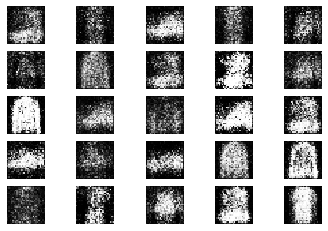

601 [D loss: 0.668443, acc.: 53.12%] [G loss: 0.935774]
602 [D loss: 0.633664, acc.: 64.06%] [G loss: 0.863818]
603 [D loss: 0.612597, acc.: 67.19%] [G loss: 0.932679]
604 [D loss: 0.661929, acc.: 60.94%] [G loss: 0.934363]
605 [D loss: 0.591410, acc.: 67.19%] [G loss: 0.948688]
606 [D loss: 0.635762, acc.: 64.06%] [G loss: 0.856369]
607 [D loss: 0.585467, acc.: 75.00%] [G loss: 0.901628]
608 [D loss: 0.584703, acc.: 73.44%] [G loss: 0.884446]
609 [D loss: 0.591647, acc.: 68.75%] [G loss: 0.937456]
610 [D loss: 0.606520, acc.: 67.19%] [G loss: 0.940690]
611 [D loss: 0.618260, acc.: 64.06%] [G loss: 0.929260]
612 [D loss: 0.587075, acc.: 68.75%] [G loss: 0.943837]
613 [D loss: 0.603599, acc.: 75.00%] [G loss: 0.930579]
614 [D loss: 0.590847, acc.: 65.62%] [G loss: 1.025276]
615 [D loss: 0.538975, acc.: 73.44%] [G loss: 0.955590]
616 [D loss: 0.650930, acc.: 64.06%] [G loss: 0.997007]
617 [D loss: 0.688191, acc.: 51.56%] [G loss: 1.044267]
618 [D loss: 0.707179, acc.: 50.00%] [G loss: 0.

750 [D loss: 0.740644, acc.: 53.12%] [G loss: 0.788995]
751 [D loss: 0.670004, acc.: 54.69%] [G loss: 0.780151]
752 [D loss: 0.613127, acc.: 65.62%] [G loss: 0.799426]
753 [D loss: 0.663410, acc.: 62.50%] [G loss: 0.810587]
754 [D loss: 0.644688, acc.: 67.19%] [G loss: 0.905814]
755 [D loss: 0.670793, acc.: 53.12%] [G loss: 0.891127]
756 [D loss: 0.640848, acc.: 65.62%] [G loss: 0.918869]
757 [D loss: 0.677726, acc.: 54.69%] [G loss: 0.825325]
758 [D loss: 0.679461, acc.: 60.94%] [G loss: 0.835155]
759 [D loss: 0.621971, acc.: 59.38%] [G loss: 0.803277]
760 [D loss: 0.612452, acc.: 64.06%] [G loss: 0.883780]
761 [D loss: 0.590928, acc.: 70.31%] [G loss: 0.886429]
762 [D loss: 0.551370, acc.: 79.69%] [G loss: 0.853814]
763 [D loss: 0.619337, acc.: 62.50%] [G loss: 0.829919]
764 [D loss: 0.596369, acc.: 59.38%] [G loss: 0.961236]
765 [D loss: 0.600898, acc.: 70.31%] [G loss: 0.914041]
766 [D loss: 0.638581, acc.: 67.19%] [G loss: 0.884601]
767 [D loss: 0.604626, acc.: 65.62%] [G loss: 0.

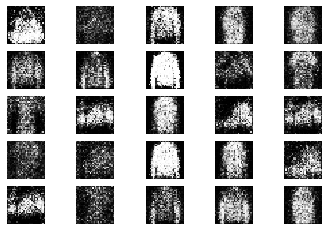

801 [D loss: 0.598686, acc.: 67.19%] [G loss: 0.930051]
802 [D loss: 0.604206, acc.: 67.19%] [G loss: 0.911475]
803 [D loss: 0.619116, acc.: 64.06%] [G loss: 0.925017]
804 [D loss: 0.630936, acc.: 62.50%] [G loss: 0.892411]
805 [D loss: 0.563565, acc.: 75.00%] [G loss: 0.941702]
806 [D loss: 0.607562, acc.: 70.31%] [G loss: 0.954845]
807 [D loss: 0.624369, acc.: 70.31%] [G loss: 0.910933]
808 [D loss: 0.584471, acc.: 60.94%] [G loss: 0.939784]
809 [D loss: 0.635618, acc.: 65.62%] [G loss: 0.911303]
810 [D loss: 0.623113, acc.: 70.31%] [G loss: 0.967530]
811 [D loss: 0.646991, acc.: 65.62%] [G loss: 0.901768]
812 [D loss: 0.560915, acc.: 76.56%] [G loss: 0.895896]
813 [D loss: 0.640744, acc.: 57.81%] [G loss: 0.898388]
814 [D loss: 0.620429, acc.: 60.94%] [G loss: 0.863981]
815 [D loss: 0.592465, acc.: 64.06%] [G loss: 0.886510]
816 [D loss: 0.659923, acc.: 53.12%] [G loss: 0.832519]
817 [D loss: 0.600372, acc.: 67.19%] [G loss: 0.910397]
818 [D loss: 0.726103, acc.: 56.25%] [G loss: 0.

951 [D loss: 0.631202, acc.: 67.19%] [G loss: 0.834312]
952 [D loss: 0.666197, acc.: 53.12%] [G loss: 0.826187]
953 [D loss: 0.634044, acc.: 60.94%] [G loss: 0.837323]
954 [D loss: 0.681158, acc.: 59.38%] [G loss: 0.832793]
955 [D loss: 0.675627, acc.: 59.38%] [G loss: 0.840575]
956 [D loss: 0.682275, acc.: 59.38%] [G loss: 0.819393]
957 [D loss: 0.700722, acc.: 53.12%] [G loss: 0.862280]
958 [D loss: 0.635036, acc.: 67.19%] [G loss: 0.784196]
959 [D loss: 0.700507, acc.: 56.25%] [G loss: 0.784716]
960 [D loss: 0.619104, acc.: 73.44%] [G loss: 0.793356]
961 [D loss: 0.634001, acc.: 59.38%] [G loss: 0.797785]
962 [D loss: 0.641348, acc.: 62.50%] [G loss: 0.809136]
963 [D loss: 0.627398, acc.: 73.44%] [G loss: 0.820746]
964 [D loss: 0.612894, acc.: 62.50%] [G loss: 0.868104]
965 [D loss: 0.659459, acc.: 54.69%] [G loss: 0.839212]
966 [D loss: 0.673152, acc.: 59.38%] [G loss: 0.749176]
967 [D loss: 0.603050, acc.: 67.19%] [G loss: 0.816385]
968 [D loss: 0.656111, acc.: 54.69%] [G loss: 0.

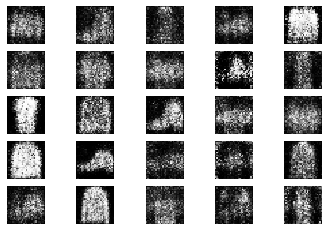

1001 [D loss: 0.616544, acc.: 70.31%] [G loss: 0.888817]
1002 [D loss: 0.679575, acc.: 59.38%] [G loss: 0.859297]
1003 [D loss: 0.643584, acc.: 59.38%] [G loss: 0.812376]
1004 [D loss: 0.641170, acc.: 60.94%] [G loss: 0.927567]
1005 [D loss: 0.646395, acc.: 64.06%] [G loss: 0.841960]
1006 [D loss: 0.711507, acc.: 45.31%] [G loss: 0.804902]
1007 [D loss: 0.619870, acc.: 56.25%] [G loss: 0.822414]
1008 [D loss: 0.602038, acc.: 68.75%] [G loss: 0.878866]
1009 [D loss: 0.705874, acc.: 59.38%] [G loss: 0.787587]
1010 [D loss: 0.620741, acc.: 75.00%] [G loss: 0.802885]
1011 [D loss: 0.694668, acc.: 51.56%] [G loss: 0.811985]
1012 [D loss: 0.570991, acc.: 70.31%] [G loss: 0.835926]
1013 [D loss: 0.707852, acc.: 50.00%] [G loss: 0.822099]
1014 [D loss: 0.680223, acc.: 51.56%] [G loss: 0.739763]
1015 [D loss: 0.575993, acc.: 71.88%] [G loss: 0.788768]
1016 [D loss: 0.633871, acc.: 64.06%] [G loss: 0.812639]
1017 [D loss: 0.658085, acc.: 64.06%] [G loss: 0.757357]
1018 [D loss: 0.616617, acc.: 6

1152 [D loss: 0.594292, acc.: 71.88%] [G loss: 0.888779]
1153 [D loss: 0.720981, acc.: 51.56%] [G loss: 0.860304]
1154 [D loss: 0.622796, acc.: 64.06%] [G loss: 0.876263]
1155 [D loss: 0.651841, acc.: 59.38%] [G loss: 0.873375]
1156 [D loss: 0.611427, acc.: 67.19%] [G loss: 0.825310]
1157 [D loss: 0.650465, acc.: 64.06%] [G loss: 0.757368]
1158 [D loss: 0.641776, acc.: 56.25%] [G loss: 0.793391]
1159 [D loss: 0.610560, acc.: 65.62%] [G loss: 0.740378]
1160 [D loss: 0.644419, acc.: 59.38%] [G loss: 0.869799]
1161 [D loss: 0.607813, acc.: 70.31%] [G loss: 0.836256]
1162 [D loss: 0.665335, acc.: 62.50%] [G loss: 0.762475]
1163 [D loss: 0.636758, acc.: 59.38%] [G loss: 0.809510]
1164 [D loss: 0.700421, acc.: 43.75%] [G loss: 0.831706]
1165 [D loss: 0.640606, acc.: 60.94%] [G loss: 0.834806]
1166 [D loss: 0.645968, acc.: 62.50%] [G loss: 0.861758]
1167 [D loss: 0.616225, acc.: 57.81%] [G loss: 0.896087]
1168 [D loss: 0.650229, acc.: 59.38%] [G loss: 0.820043]
1169 [D loss: 0.661951, acc.: 5

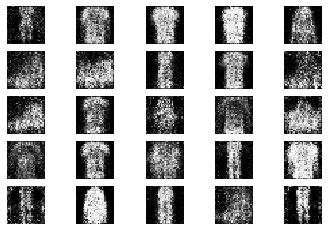

1201 [D loss: 0.640269, acc.: 64.06%] [G loss: 0.838268]
1202 [D loss: 0.677426, acc.: 67.19%] [G loss: 0.803244]
1203 [D loss: 0.658275, acc.: 68.75%] [G loss: 0.764027]
1204 [D loss: 0.652608, acc.: 57.81%] [G loss: 0.828532]
1205 [D loss: 0.627291, acc.: 62.50%] [G loss: 0.833453]
1206 [D loss: 0.649966, acc.: 54.69%] [G loss: 0.846565]
1207 [D loss: 0.666552, acc.: 54.69%] [G loss: 0.869257]
1208 [D loss: 0.666591, acc.: 64.06%] [G loss: 0.804982]
1209 [D loss: 0.652888, acc.: 67.19%] [G loss: 0.852302]
1210 [D loss: 0.699653, acc.: 54.69%] [G loss: 0.804249]
1211 [D loss: 0.649087, acc.: 59.38%] [G loss: 0.867416]
1212 [D loss: 0.642861, acc.: 64.06%] [G loss: 0.797924]
1213 [D loss: 0.631744, acc.: 64.06%] [G loss: 0.844753]
1214 [D loss: 0.651024, acc.: 57.81%] [G loss: 0.760024]
1215 [D loss: 0.645252, acc.: 62.50%] [G loss: 0.816239]
1216 [D loss: 0.690250, acc.: 54.69%] [G loss: 0.857107]
1217 [D loss: 0.610430, acc.: 67.19%] [G loss: 0.842069]
1218 [D loss: 0.658352, acc.: 6

1352 [D loss: 0.683814, acc.: 51.56%] [G loss: 0.832422]
1353 [D loss: 0.634685, acc.: 60.94%] [G loss: 0.912136]
1354 [D loss: 0.638415, acc.: 60.94%] [G loss: 0.923860]
1355 [D loss: 0.614419, acc.: 68.75%] [G loss: 0.846542]
1356 [D loss: 0.660951, acc.: 60.94%] [G loss: 0.882842]
1357 [D loss: 0.669094, acc.: 56.25%] [G loss: 0.890143]
1358 [D loss: 0.584132, acc.: 71.88%] [G loss: 0.871142]
1359 [D loss: 0.692786, acc.: 53.12%] [G loss: 0.873605]
1360 [D loss: 0.592311, acc.: 73.44%] [G loss: 0.865266]
1361 [D loss: 0.624965, acc.: 65.62%] [G loss: 0.835656]
1362 [D loss: 0.635223, acc.: 60.94%] [G loss: 0.838352]
1363 [D loss: 0.586462, acc.: 75.00%] [G loss: 0.802487]
1364 [D loss: 0.683538, acc.: 54.69%] [G loss: 0.811306]
1365 [D loss: 0.632028, acc.: 62.50%] [G loss: 0.861908]
1366 [D loss: 0.639287, acc.: 57.81%] [G loss: 0.863849]
1367 [D loss: 0.642713, acc.: 59.38%] [G loss: 0.824648]
1368 [D loss: 0.662802, acc.: 62.50%] [G loss: 0.845841]
1369 [D loss: 0.632393, acc.: 5

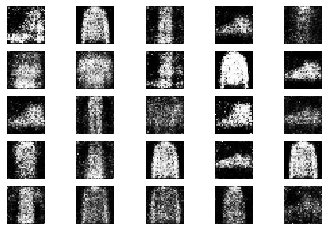

1401 [D loss: 0.679510, acc.: 59.38%] [G loss: 0.822513]
1402 [D loss: 0.597414, acc.: 73.44%] [G loss: 0.862557]
1403 [D loss: 0.601860, acc.: 70.31%] [G loss: 0.862390]
1404 [D loss: 0.708374, acc.: 50.00%] [G loss: 0.853563]
1405 [D loss: 0.669771, acc.: 60.94%] [G loss: 0.765191]
1406 [D loss: 0.623205, acc.: 65.62%] [G loss: 0.801942]
1407 [D loss: 0.607123, acc.: 73.44%] [G loss: 0.769902]
1408 [D loss: 0.608837, acc.: 65.62%] [G loss: 0.888830]
1409 [D loss: 0.676517, acc.: 51.56%] [G loss: 0.871631]
1410 [D loss: 0.574874, acc.: 79.69%] [G loss: 0.892600]
1411 [D loss: 0.644374, acc.: 60.94%] [G loss: 0.829746]
1412 [D loss: 0.606021, acc.: 68.75%] [G loss: 0.789916]
1413 [D loss: 0.660537, acc.: 60.94%] [G loss: 0.847211]
1414 [D loss: 0.650754, acc.: 59.38%] [G loss: 0.927291]
1415 [D loss: 0.654970, acc.: 65.62%] [G loss: 0.887495]
1416 [D loss: 0.633942, acc.: 68.75%] [G loss: 0.793510]
1417 [D loss: 0.654940, acc.: 56.25%] [G loss: 0.840567]
1418 [D loss: 0.593842, acc.: 6

1546 [D loss: 0.615474, acc.: 64.06%] [G loss: 0.848497]
1547 [D loss: 0.639725, acc.: 65.62%] [G loss: 0.871384]
1548 [D loss: 0.610193, acc.: 73.44%] [G loss: 0.793203]
1549 [D loss: 0.574322, acc.: 65.62%] [G loss: 0.890362]
1550 [D loss: 0.585162, acc.: 71.88%] [G loss: 0.802364]
1551 [D loss: 0.687951, acc.: 57.81%] [G loss: 0.890533]
1552 [D loss: 0.617651, acc.: 70.31%] [G loss: 0.771900]
1553 [D loss: 0.626429, acc.: 68.75%] [G loss: 0.878493]
1554 [D loss: 0.672851, acc.: 56.25%] [G loss: 0.826097]
1555 [D loss: 0.603599, acc.: 64.06%] [G loss: 0.815024]
1556 [D loss: 0.612560, acc.: 71.88%] [G loss: 0.968523]
1557 [D loss: 0.682720, acc.: 59.38%] [G loss: 0.941744]
1558 [D loss: 0.597382, acc.: 75.00%] [G loss: 0.819484]
1559 [D loss: 0.682686, acc.: 60.94%] [G loss: 0.892229]
1560 [D loss: 0.658050, acc.: 62.50%] [G loss: 0.894897]
1561 [D loss: 0.657858, acc.: 57.81%] [G loss: 0.898136]
1562 [D loss: 0.628146, acc.: 60.94%] [G loss: 0.843652]
1563 [D loss: 0.652116, acc.: 6

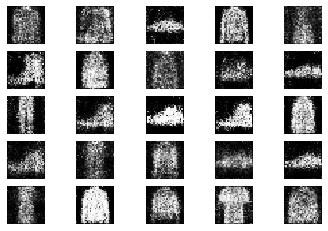

1601 [D loss: 0.634653, acc.: 65.62%] [G loss: 0.867612]
1602 [D loss: 0.573390, acc.: 75.00%] [G loss: 0.883029]
1603 [D loss: 0.612081, acc.: 60.94%] [G loss: 0.745597]
1604 [D loss: 0.618180, acc.: 65.62%] [G loss: 0.891196]
1605 [D loss: 0.592410, acc.: 68.75%] [G loss: 0.867169]
1606 [D loss: 0.665074, acc.: 59.38%] [G loss: 0.871605]
1607 [D loss: 0.608524, acc.: 71.88%] [G loss: 0.883238]
1608 [D loss: 0.610502, acc.: 65.62%] [G loss: 0.900208]
1609 [D loss: 0.635292, acc.: 64.06%] [G loss: 0.843819]
1610 [D loss: 0.637820, acc.: 64.06%] [G loss: 0.804355]
1611 [D loss: 0.688647, acc.: 50.00%] [G loss: 0.868327]
1612 [D loss: 0.627933, acc.: 64.06%] [G loss: 0.876623]
1613 [D loss: 0.627249, acc.: 65.62%] [G loss: 0.905518]
1614 [D loss: 0.623999, acc.: 64.06%] [G loss: 0.902797]
1615 [D loss: 0.635654, acc.: 65.62%] [G loss: 0.836184]
1616 [D loss: 0.656852, acc.: 64.06%] [G loss: 0.813723]
1617 [D loss: 0.615773, acc.: 60.94%] [G loss: 0.841396]
1618 [D loss: 0.627795, acc.: 6

1753 [D loss: 0.621697, acc.: 73.44%] [G loss: 0.864457]
1754 [D loss: 0.626145, acc.: 68.75%] [G loss: 0.861513]
1755 [D loss: 0.610550, acc.: 68.75%] [G loss: 0.977455]
1756 [D loss: 0.676219, acc.: 56.25%] [G loss: 0.913553]
1757 [D loss: 0.641272, acc.: 60.94%] [G loss: 0.883626]
1758 [D loss: 0.616353, acc.: 62.50%] [G loss: 0.796626]
1759 [D loss: 0.606781, acc.: 68.75%] [G loss: 0.896133]
1760 [D loss: 0.640532, acc.: 60.94%] [G loss: 0.956258]
1761 [D loss: 0.652398, acc.: 59.38%] [G loss: 0.908998]
1762 [D loss: 0.601667, acc.: 67.19%] [G loss: 0.935777]
1763 [D loss: 0.661284, acc.: 57.81%] [G loss: 0.879350]
1764 [D loss: 0.637299, acc.: 67.19%] [G loss: 0.845743]
1765 [D loss: 0.643957, acc.: 67.19%] [G loss: 0.851002]
1766 [D loss: 0.655908, acc.: 60.94%] [G loss: 0.915277]
1767 [D loss: 0.665191, acc.: 56.25%] [G loss: 0.968822]
1768 [D loss: 0.653966, acc.: 65.62%] [G loss: 0.781826]
1769 [D loss: 0.643535, acc.: 75.00%] [G loss: 0.853520]
1770 [D loss: 0.612342, acc.: 6

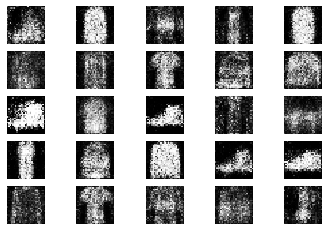

1801 [D loss: 0.630716, acc.: 67.19%] [G loss: 0.899139]
1802 [D loss: 0.614923, acc.: 67.19%] [G loss: 0.898242]
1803 [D loss: 0.691219, acc.: 59.38%] [G loss: 0.892061]
1804 [D loss: 0.576174, acc.: 67.19%] [G loss: 0.868467]
1805 [D loss: 0.637152, acc.: 60.94%] [G loss: 0.766453]
1806 [D loss: 0.601597, acc.: 65.62%] [G loss: 0.798270]
1807 [D loss: 0.607230, acc.: 64.06%] [G loss: 0.864627]
1808 [D loss: 0.684165, acc.: 54.69%] [G loss: 0.905655]
1809 [D loss: 0.641805, acc.: 60.94%] [G loss: 0.844976]
1810 [D loss: 0.659220, acc.: 56.25%] [G loss: 0.790511]
1811 [D loss: 0.607013, acc.: 60.94%] [G loss: 0.834840]
1812 [D loss: 0.654094, acc.: 53.12%] [G loss: 0.962584]
1813 [D loss: 0.627715, acc.: 68.75%] [G loss: 0.980447]
1814 [D loss: 0.676647, acc.: 57.81%] [G loss: 0.904295]
1815 [D loss: 0.657655, acc.: 65.62%] [G loss: 0.931216]
1816 [D loss: 0.627096, acc.: 70.31%] [G loss: 0.867251]
1817 [D loss: 0.634409, acc.: 68.75%] [G loss: 0.877376]
1818 [D loss: 0.660586, acc.: 5

1952 [D loss: 0.644677, acc.: 59.38%] [G loss: 0.946877]
1953 [D loss: 0.653864, acc.: 65.62%] [G loss: 0.891393]
1954 [D loss: 0.608263, acc.: 67.19%] [G loss: 0.883908]
1955 [D loss: 0.584097, acc.: 67.19%] [G loss: 0.852967]
1956 [D loss: 0.607677, acc.: 68.75%] [G loss: 0.875059]
1957 [D loss: 0.588929, acc.: 70.31%] [G loss: 0.916141]
1958 [D loss: 0.632586, acc.: 60.94%] [G loss: 0.902642]
1959 [D loss: 0.634337, acc.: 64.06%] [G loss: 0.977972]
1960 [D loss: 0.609238, acc.: 65.62%] [G loss: 0.865617]
1961 [D loss: 0.656094, acc.: 53.12%] [G loss: 0.903446]
1962 [D loss: 0.645596, acc.: 54.69%] [G loss: 0.901212]
1963 [D loss: 0.627174, acc.: 65.62%] [G loss: 1.012111]
1964 [D loss: 0.635516, acc.: 67.19%] [G loss: 0.942604]
1965 [D loss: 0.644294, acc.: 59.38%] [G loss: 0.919628]
1966 [D loss: 0.622955, acc.: 67.19%] [G loss: 0.998636]
1967 [D loss: 0.618389, acc.: 64.06%] [G loss: 0.902891]
1968 [D loss: 0.648184, acc.: 62.50%] [G loss: 0.832074]
1969 [D loss: 0.582033, acc.: 6

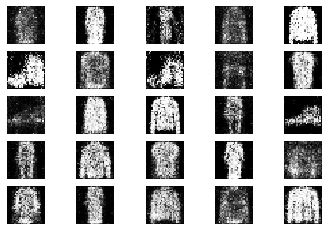

2001 [D loss: 0.602877, acc.: 71.88%] [G loss: 0.946592]
2002 [D loss: 0.637701, acc.: 71.88%] [G loss: 0.869632]
2003 [D loss: 0.527782, acc.: 79.69%] [G loss: 0.873607]
2004 [D loss: 0.616344, acc.: 70.31%] [G loss: 0.890552]
2005 [D loss: 0.633816, acc.: 64.06%] [G loss: 0.864722]
2006 [D loss: 0.614307, acc.: 64.06%] [G loss: 0.859393]
2007 [D loss: 0.662281, acc.: 56.25%] [G loss: 0.921464]
2008 [D loss: 0.632643, acc.: 64.06%] [G loss: 0.852482]
2009 [D loss: 0.567696, acc.: 70.31%] [G loss: 0.877648]
2010 [D loss: 0.669363, acc.: 57.81%] [G loss: 0.883061]
2011 [D loss: 0.596087, acc.: 70.31%] [G loss: 0.908732]
2012 [D loss: 0.655873, acc.: 59.38%] [G loss: 0.933741]
2013 [D loss: 0.657545, acc.: 56.25%] [G loss: 0.992282]
2014 [D loss: 0.615626, acc.: 67.19%] [G loss: 1.015150]
2015 [D loss: 0.666288, acc.: 54.69%] [G loss: 0.977323]
2016 [D loss: 0.646329, acc.: 57.81%] [G loss: 0.882207]
2017 [D loss: 0.650998, acc.: 59.38%] [G loss: 0.915024]
2018 [D loss: 0.622626, acc.: 6

2151 [D loss: 0.604445, acc.: 71.88%] [G loss: 0.906662]
2152 [D loss: 0.644119, acc.: 64.06%] [G loss: 0.896844]
2153 [D loss: 0.674226, acc.: 57.81%] [G loss: 0.891822]
2154 [D loss: 0.627356, acc.: 65.62%] [G loss: 0.868283]
2155 [D loss: 0.645494, acc.: 62.50%] [G loss: 0.909653]
2156 [D loss: 0.655033, acc.: 60.94%] [G loss: 0.864664]
2157 [D loss: 0.567732, acc.: 65.62%] [G loss: 0.881387]
2158 [D loss: 0.650963, acc.: 56.25%] [G loss: 0.899229]
2159 [D loss: 0.638672, acc.: 59.38%] [G loss: 0.940973]
2160 [D loss: 0.631390, acc.: 57.81%] [G loss: 0.851457]
2161 [D loss: 0.629354, acc.: 56.25%] [G loss: 0.934828]
2162 [D loss: 0.615494, acc.: 65.62%] [G loss: 0.987130]
2163 [D loss: 0.620773, acc.: 60.94%] [G loss: 0.909878]
2164 [D loss: 0.620491, acc.: 65.62%] [G loss: 0.897120]
2165 [D loss: 0.679394, acc.: 57.81%] [G loss: 0.947648]
2166 [D loss: 0.593602, acc.: 65.62%] [G loss: 0.883164]
2167 [D loss: 0.597061, acc.: 71.88%] [G loss: 1.003621]
2168 [D loss: 0.618826, acc.: 6

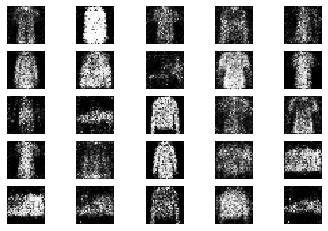

2201 [D loss: 0.598173, acc.: 70.31%] [G loss: 0.982420]
2202 [D loss: 0.575075, acc.: 76.56%] [G loss: 0.825939]
2203 [D loss: 0.645077, acc.: 65.62%] [G loss: 0.873738]
2204 [D loss: 0.548618, acc.: 73.44%] [G loss: 1.036044]
2205 [D loss: 0.625566, acc.: 59.38%] [G loss: 0.942367]
2206 [D loss: 0.648733, acc.: 65.62%] [G loss: 0.855223]
2207 [D loss: 0.647634, acc.: 60.94%] [G loss: 1.025576]
2208 [D loss: 0.606500, acc.: 67.19%] [G loss: 1.004799]
2209 [D loss: 0.608505, acc.: 65.62%] [G loss: 0.962333]
2210 [D loss: 0.636394, acc.: 65.62%] [G loss: 0.921063]
2211 [D loss: 0.615726, acc.: 60.94%] [G loss: 0.944443]
2212 [D loss: 0.641052, acc.: 60.94%] [G loss: 0.903111]
2213 [D loss: 0.594343, acc.: 60.94%] [G loss: 0.939619]
2214 [D loss: 0.614647, acc.: 68.75%] [G loss: 0.964961]
2215 [D loss: 0.669229, acc.: 56.25%] [G loss: 0.873887]
2216 [D loss: 0.582806, acc.: 70.31%] [G loss: 0.937490]
2217 [D loss: 0.664170, acc.: 64.06%] [G loss: 0.901820]
2218 [D loss: 0.598293, acc.: 6

2352 [D loss: 0.606283, acc.: 67.19%] [G loss: 0.891050]
2353 [D loss: 0.653140, acc.: 51.56%] [G loss: 0.895473]
2354 [D loss: 0.589675, acc.: 70.31%] [G loss: 0.946312]
2355 [D loss: 0.608090, acc.: 68.75%] [G loss: 0.837239]
2356 [D loss: 0.617515, acc.: 65.62%] [G loss: 0.869597]
2357 [D loss: 0.630687, acc.: 60.94%] [G loss: 0.935690]
2358 [D loss: 0.633935, acc.: 60.94%] [G loss: 0.920096]
2359 [D loss: 0.603888, acc.: 62.50%] [G loss: 0.961039]
2360 [D loss: 0.647406, acc.: 57.81%] [G loss: 0.970558]
2361 [D loss: 0.643597, acc.: 62.50%] [G loss: 0.882707]
2362 [D loss: 0.684214, acc.: 59.38%] [G loss: 0.869344]
2363 [D loss: 0.664495, acc.: 67.19%] [G loss: 0.859592]
2364 [D loss: 0.593250, acc.: 71.88%] [G loss: 0.952929]
2365 [D loss: 0.646881, acc.: 62.50%] [G loss: 0.916779]
2366 [D loss: 0.618469, acc.: 68.75%] [G loss: 0.922642]
2367 [D loss: 0.622783, acc.: 70.31%] [G loss: 0.934035]
2368 [D loss: 0.679900, acc.: 57.81%] [G loss: 0.836684]
2369 [D loss: 0.598268, acc.: 6

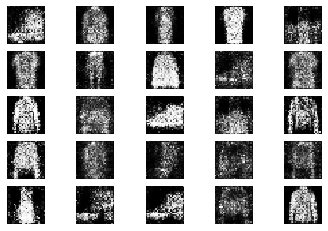

2401 [D loss: 0.637662, acc.: 64.06%] [G loss: 0.895106]
2402 [D loss: 0.576382, acc.: 71.88%] [G loss: 0.808648]
2403 [D loss: 0.625888, acc.: 60.94%] [G loss: 0.862617]
2404 [D loss: 0.586646, acc.: 71.88%] [G loss: 0.827948]
2405 [D loss: 0.653751, acc.: 57.81%] [G loss: 0.835841]
2406 [D loss: 0.609131, acc.: 59.38%] [G loss: 0.819347]
2407 [D loss: 0.627324, acc.: 60.94%] [G loss: 0.919953]
2408 [D loss: 0.665265, acc.: 56.25%] [G loss: 0.864144]
2409 [D loss: 0.579745, acc.: 59.38%] [G loss: 0.907562]
2410 [D loss: 0.632148, acc.: 59.38%] [G loss: 0.867286]
2411 [D loss: 0.644218, acc.: 68.75%] [G loss: 0.898258]
2412 [D loss: 0.680524, acc.: 56.25%] [G loss: 0.948086]
2413 [D loss: 0.691664, acc.: 43.75%] [G loss: 1.029355]
2414 [D loss: 0.622190, acc.: 68.75%] [G loss: 0.944429]
2415 [D loss: 0.607499, acc.: 68.75%] [G loss: 0.961331]
2416 [D loss: 0.645123, acc.: 54.69%] [G loss: 0.959610]
2417 [D loss: 0.611365, acc.: 71.88%] [G loss: 0.956383]
2418 [D loss: 0.658108, acc.: 6

2552 [D loss: 0.631825, acc.: 68.75%] [G loss: 0.956417]
2553 [D loss: 0.622364, acc.: 57.81%] [G loss: 0.970541]
2554 [D loss: 0.641958, acc.: 64.06%] [G loss: 0.954025]
2555 [D loss: 0.642326, acc.: 56.25%] [G loss: 1.003330]
2556 [D loss: 0.617896, acc.: 67.19%] [G loss: 0.995358]
2557 [D loss: 0.601993, acc.: 65.62%] [G loss: 0.960758]
2558 [D loss: 0.669569, acc.: 62.50%] [G loss: 0.947656]
2559 [D loss: 0.676670, acc.: 48.44%] [G loss: 0.885060]
2560 [D loss: 0.664205, acc.: 57.81%] [G loss: 0.944482]
2561 [D loss: 0.591752, acc.: 76.56%] [G loss: 0.960745]
2562 [D loss: 0.639633, acc.: 60.94%] [G loss: 0.969970]
2563 [D loss: 0.533055, acc.: 76.56%] [G loss: 1.044275]
2564 [D loss: 0.617215, acc.: 70.31%] [G loss: 0.905234]
2565 [D loss: 0.644129, acc.: 60.94%] [G loss: 0.946493]
2566 [D loss: 0.671438, acc.: 53.12%] [G loss: 0.926136]
2567 [D loss: 0.634511, acc.: 64.06%] [G loss: 1.035251]
2568 [D loss: 0.703417, acc.: 50.00%] [G loss: 0.963546]
2569 [D loss: 0.684304, acc.: 5

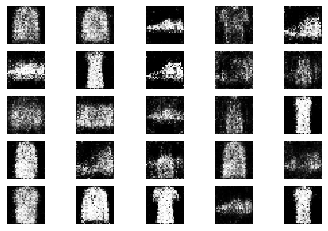

2601 [D loss: 0.685635, acc.: 59.38%] [G loss: 0.880751]
2602 [D loss: 0.651011, acc.: 57.81%] [G loss: 0.930075]
2603 [D loss: 0.605570, acc.: 67.19%] [G loss: 0.855390]
2604 [D loss: 0.619947, acc.: 64.06%] [G loss: 0.987349]
2605 [D loss: 0.577423, acc.: 67.19%] [G loss: 0.941862]
2606 [D loss: 0.605438, acc.: 70.31%] [G loss: 0.920969]
2607 [D loss: 0.673550, acc.: 48.44%] [G loss: 0.898028]
2608 [D loss: 0.660673, acc.: 65.62%] [G loss: 0.977106]
2609 [D loss: 0.619911, acc.: 64.06%] [G loss: 0.929425]
2610 [D loss: 0.578840, acc.: 67.19%] [G loss: 0.902517]
2611 [D loss: 0.652165, acc.: 54.69%] [G loss: 0.951027]
2612 [D loss: 0.607232, acc.: 68.75%] [G loss: 0.894694]
2613 [D loss: 0.624894, acc.: 62.50%] [G loss: 0.836927]
2614 [D loss: 0.642903, acc.: 60.94%] [G loss: 0.978650]
2615 [D loss: 0.660151, acc.: 59.38%] [G loss: 0.858835]
2616 [D loss: 0.651757, acc.: 59.38%] [G loss: 0.923192]
2617 [D loss: 0.675319, acc.: 60.94%] [G loss: 0.869735]
2618 [D loss: 0.580535, acc.: 7

2750 [D loss: 0.644560, acc.: 59.38%] [G loss: 0.835703]
2751 [D loss: 0.703321, acc.: 59.38%] [G loss: 0.996836]
2752 [D loss: 0.602530, acc.: 70.31%] [G loss: 0.882429]
2753 [D loss: 0.596138, acc.: 68.75%] [G loss: 0.892279]
2754 [D loss: 0.676803, acc.: 59.38%] [G loss: 0.931286]
2755 [D loss: 0.653270, acc.: 60.94%] [G loss: 0.993470]
2756 [D loss: 0.560750, acc.: 78.12%] [G loss: 0.962326]
2757 [D loss: 0.636130, acc.: 64.06%] [G loss: 0.934610]
2758 [D loss: 0.753104, acc.: 50.00%] [G loss: 0.885295]
2759 [D loss: 0.617131, acc.: 68.75%] [G loss: 0.961168]
2760 [D loss: 0.651483, acc.: 65.62%] [G loss: 0.892497]
2761 [D loss: 0.664636, acc.: 60.94%] [G loss: 0.921995]
2762 [D loss: 0.683002, acc.: 67.19%] [G loss: 0.997499]
2763 [D loss: 0.667769, acc.: 56.25%] [G loss: 0.997019]
2764 [D loss: 0.610719, acc.: 70.31%] [G loss: 1.022325]
2765 [D loss: 0.618970, acc.: 64.06%] [G loss: 0.932103]
2766 [D loss: 0.674028, acc.: 60.94%] [G loss: 0.898902]
2767 [D loss: 0.655055, acc.: 6

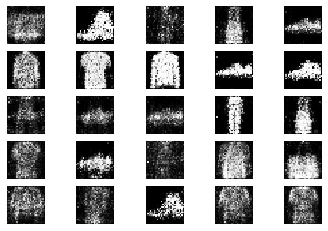

2801 [D loss: 0.646307, acc.: 64.06%] [G loss: 0.944939]
2802 [D loss: 0.634320, acc.: 54.69%] [G loss: 0.828120]
2803 [D loss: 0.662934, acc.: 65.62%] [G loss: 0.879430]
2804 [D loss: 0.611789, acc.: 71.88%] [G loss: 0.877084]
2805 [D loss: 0.619566, acc.: 70.31%] [G loss: 0.822682]
2806 [D loss: 0.642669, acc.: 64.06%] [G loss: 0.872380]
2807 [D loss: 0.621125, acc.: 70.31%] [G loss: 0.937527]
2808 [D loss: 0.639858, acc.: 60.94%] [G loss: 0.939385]
2809 [D loss: 0.647343, acc.: 64.06%] [G loss: 0.930250]
2810 [D loss: 0.623409, acc.: 57.81%] [G loss: 0.920922]
2811 [D loss: 0.680540, acc.: 54.69%] [G loss: 0.913257]
2812 [D loss: 0.614726, acc.: 59.38%] [G loss: 0.982659]
2813 [D loss: 0.649660, acc.: 59.38%] [G loss: 0.946264]
2814 [D loss: 0.709527, acc.: 51.56%] [G loss: 0.982657]
2815 [D loss: 0.587743, acc.: 73.44%] [G loss: 0.912935]
2816 [D loss: 0.596937, acc.: 70.31%] [G loss: 0.897443]
2817 [D loss: 0.572203, acc.: 70.31%] [G loss: 0.839406]
2818 [D loss: 0.586707, acc.: 7

2950 [D loss: 0.638563, acc.: 62.50%] [G loss: 0.809677]
2951 [D loss: 0.647865, acc.: 62.50%] [G loss: 0.814885]
2952 [D loss: 0.670605, acc.: 60.94%] [G loss: 0.879888]
2953 [D loss: 0.631230, acc.: 59.38%] [G loss: 0.908631]
2954 [D loss: 0.615633, acc.: 68.75%] [G loss: 0.921225]
2955 [D loss: 0.618706, acc.: 67.19%] [G loss: 0.907323]
2956 [D loss: 0.615144, acc.: 68.75%] [G loss: 0.934725]
2957 [D loss: 0.700225, acc.: 54.69%] [G loss: 0.892933]
2958 [D loss: 0.658952, acc.: 60.94%] [G loss: 0.884441]
2959 [D loss: 0.621511, acc.: 56.25%] [G loss: 0.880921]
2960 [D loss: 0.683216, acc.: 60.94%] [G loss: 0.859107]
2961 [D loss: 0.634445, acc.: 60.94%] [G loss: 0.840840]
2962 [D loss: 0.591363, acc.: 67.19%] [G loss: 0.880821]
2963 [D loss: 0.608370, acc.: 73.44%] [G loss: 0.964517]
2964 [D loss: 0.603094, acc.: 68.75%] [G loss: 0.908046]
2965 [D loss: 0.593993, acc.: 75.00%] [G loss: 1.029738]
2966 [D loss: 0.679722, acc.: 56.25%] [G loss: 1.017381]
2967 [D loss: 0.570737, acc.: 7

In [21]:
for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        sample_images(epoch, latent_dim, generator)

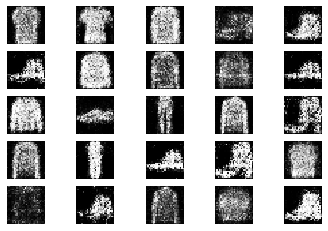

In [22]:
sample_images(epoch, latent_dim, generator)